# A quick & dirty introduction to DAMIC analysis in Python 

The DAMIC experiment uses CCDs (Charge Coupled Devices) - much like the ones found in your cell phone camera - to effectively take images of particles. Very roughly, incident particles (e-, $\mu-$, $\alpha$ etc.) interact in the bulk of the device and create electron-hole pairs. The holes are drifted by an applied electric field and are then collected for read out by "clocking" (moving charge by changing voltages in the pixel). You move entire rows downward one at a time (y-direction, vertical) and dump them into the "serial register". You then clock horizontally (x-direction) a pixel at a time and read out the value in the output node. Even though energy is deposited in e-, the pixels are read out in ADU (Analog-to-Digital Units). There is a conversion constant $c$ between e- $\to$ ADU we will find later. The particular CCD we will be working with is split into roughly 4116x2040 "pixels" each of 15 $\mu$m$^2$ having an overall thickness of 675 $\mu$m. A cross-section of a pixel and read out process is shown along with an example of particle identification in a raw image: <img src="Misc/Pixel.png" style="width: 500px;"> <img src="Misc/eximage.png" style="width: 600px;"> 

## Overview

The "FITS" folder contains a selection of 5 images taken with a DAMIC CCD at the University of Chicago that have been exposed to an Fe-55 (radioactive isotope of Iron) source. The goal is to process these images and reconstruct the energy deposits within so as to create an energy spectrum - a histogram of events in energy space - and get the calibration constant $c$

## Loading Data

Fits files (".fits") are a standard image container format commonly used in astronomy. This is how all DAMIC data is stored.  You can download and use the "ds9" software to open these files (use histogram scaling when viewing images with this software). However to programatically read the images, we will use the astropy package and work with just 1 file. 

In [4]:
from astropy.io import fits
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,9]
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit

In [2]:
hdul = fits.open('FITS/Image104660.fits')
scidata = hdul[0].data
scidata.shape

(2100, 4200)

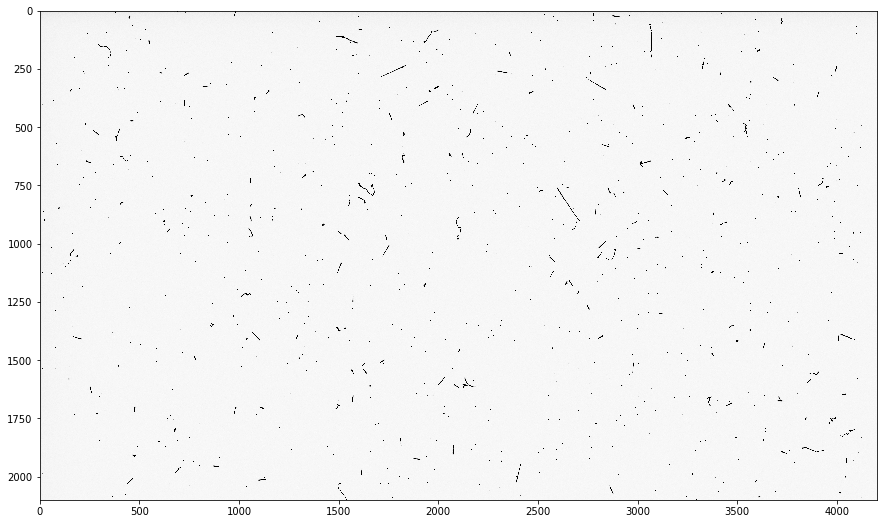

In [5]:
plt.imshow(scidata,vmin=3800,vmax=4900,cmap='Greys',aspect='auto')

## Cleaning the Image

Before we can reconstruct clusters (i.e. energy deposits) we need to prep the image. A few points:
1. If you look at the header (contains information about the image like size, exposure time etc.) you see that "data" portion of the image is actually smaller than the full image size of 4100x2100 pixels. The remainder of the pixels are what is called the overscan. The x-overscan is caused by reading out the output node more times than the number of columns. These pixels *will not* contain external charge. The y-overscan is created by continuing to clock more rows past the end of the CCD. These *may* contain charge. Let's define some central region of the image that we will use for the analysis.

In [6]:
hdul[0].header['DATASEC']

'[11:4124,1:2040]'

In [7]:
datasec = scidata[200:1800,200:3800] # Let's ignore the ends of the images

2. When the electronics reads out a pixel there is unfortunately noise added. This is around 2e- for these images. This means that if there was actually say 12e- in a pixel by a deposited particle we will instead read out a random variable p ~ Gaus(12,2). We can get a quick sense of this spread by just histogramming the pixels in the x-overscan.

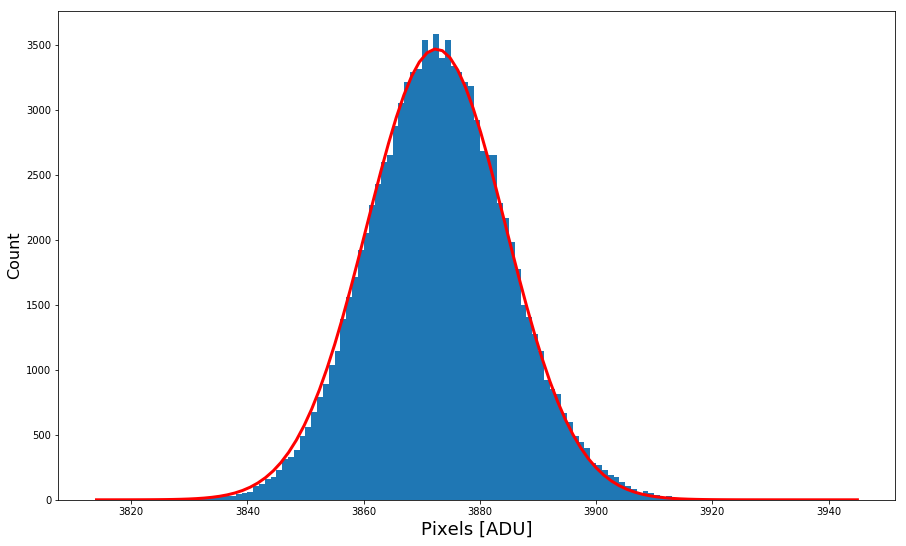

(3872.491548076923, 11.963106174160083)

In [8]:
xovsc = scidata[200:1800,4135:4200].flatten();
mean,std=norm.fit(xovsc.flatten())
plt.hist(xovsc.flatten(), bins=range(3820,3940,1));
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)*xovsc.size
plt.plot(x, y,'r',linewidth=3);
plt.xlabel('Pixels [ADU]', fontsize=18);
plt.ylabel('Count', fontsize=16);
plt.show();
mean, std # mu, sigma_{pix}

3. There is also an added baseline ("pedestal"). This means that pixels with no charge are not around 0 ADU but have some offset to them. You can see that in our image the mean is roughly ~3870. We can go ahead and subtract this off so we will have an image with roughly 0 mean.

In [9]:
datasec = datasec-mean

## Analysis

Now we have a "corrected" image. We need to identify energy deposits in this. The simplest way is to define a cluster as a contiguous (touching in any of the 8 directions) series of pixels all with values > $4\sigma_{pix}$. The quickest implementation of this algorithm is by recursion.

In [10]:
searched = np.zeros(datasec.shape)
energy = np.zeros(datasec.shape)

In [11]:
from sys import getrecursionlimit, setrecursionlimit
setrecursionlimit(2000)

In [12]:
xmax = len(datasec[0])
ymax = len(datasec)

def findnext(x,y):
    
    etot = 0
    
    if ((x<0) or (y<0) or (x>=xmax) or (y>=ymax) or (searched[y][x]==1)):
        return 0

    searched[y][x] = 1
    
    if (datasec[y,x]>=4*std):
        etot+=datasec[y][x]
    else:
        return 0
    
        
    etot+=findnext(x-1,y+1)
    etot+=findnext(x-1,y)
    etot+=findnext(x-1,y-1)
    etot+=findnext(x,y-1)
    etot+=findnext(x,y+1)
    etot+=findnext(x+1,y+1)
    etot+=findnext(x+1,y)
    etot+=findnext(x+1,y+1)
    
    return etot
    
E = []
        
for x in range(len(datasec[0])):
    for y in range(len(datasec)):
        currE = 0
        if ((datasec[y,x]>=4*std) and (searched[y][x]!=1)):
            currE += findnext(x,y)
            E.append(currE)
        
E = np.array(E)

E now contains a list of energies corresponding to each cluster identified in the image.

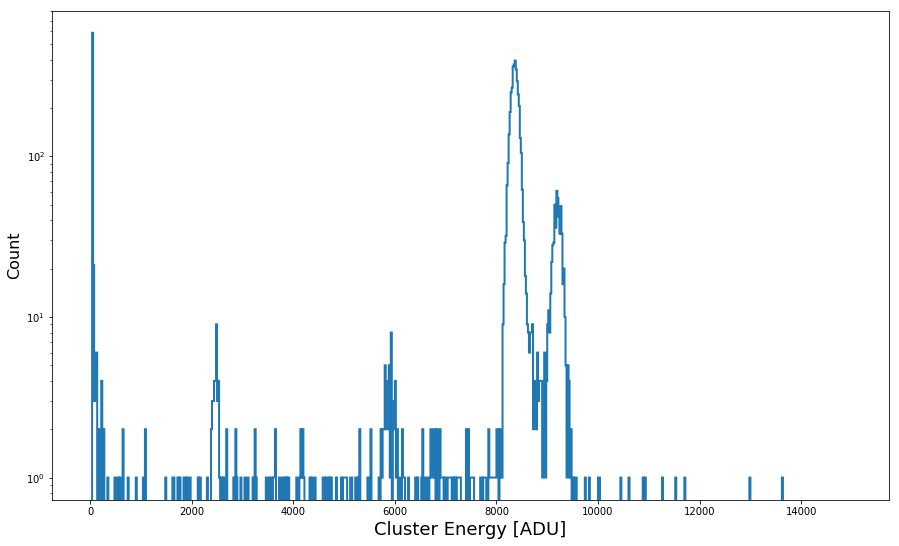

In [13]:
plt.hist(E, bins=range(0,15000,20),histtype='step',linewidth=2);
plt.yscale('log');
plt.xlabel('Cluster Energy [ADU]', fontsize=18);
plt.ylabel('Count', fontsize=16);

And we can immediately see the Iron-55 dominant peaks pop out in the energy spectrum. From a look up table we know that the energy of the major peak is 5.9 keV and thus fit a Gaussian to it to extract the calibration constant. <img src="Misc/xray.png" style="width: 400px;">

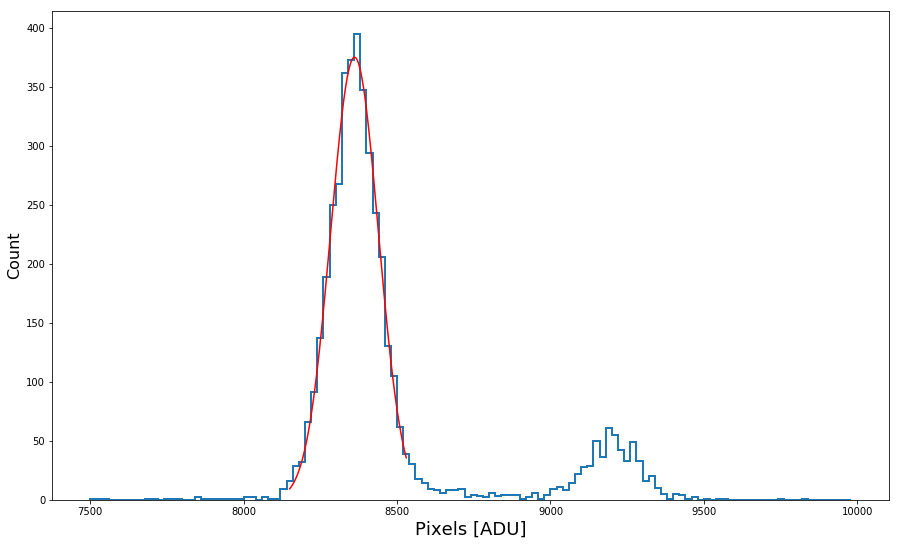

8361.348637499834

In [15]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

bin_heights, bin_borders = np.histogram(E, bins=range(8150,8550,20))
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2

popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[8300., 100, 5])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
plt.figure()
plt.hist(E, bins=range(7500,10000,20),histtype='step',linewidth=2);
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), c='r')

plt.xlabel('Pixels [ADU]', fontsize=18);
plt.ylabel('Count', fontsize=16);
plt.show();

popt[0]

So the calibration constant $c\approx\frac{5.9}{8361}\approx7\times10^{-4}$ keV/ADU and the noise of the image is (using an electron-hole pair ionization energy in Silicon of 3.77 eV/e-) is $\sigma_{pix} \approx 11.96 \cdot 7\times10^{-4}\cdot 1000 \cdot \frac{1}{3.77}\approx2.22e^{-}$ which is in line with expectations.